# Convex hull as an index to support an algorithm for the mutualisation of itineraires - to see it renderd visit https://nbviewer.org/github/Universite-Gustave-Eiffel/geodev-logicout/blob/Thiago/notebooks/convex_hull.ipynb

In [13]:
import sys  
sys.path.insert(0, '../scripts')
import use_data
import IsInclude
from shapely import wkt
import geopandas as gpd
import matplotlib.pyplot as plt

In [14]:
# we initialize the parameters for the geodataframe
dist = 100000
D = [50e3, 100e3, 150e3]

filename = "simulations_reel_gdf.csv"
gdf = use_data.create_gdf(filename,'cheflieu')

In [15]:
sampleA = gdf.iloc[[1]]
id_simu_A = sampleA['id_simulation']

id_simu_tot = IsInclude.IsIn_tournee_gdf(sampleA, gdf, dist, 1)['id_simulation_right'].values
id_simu_double = IsInclude.IsIn_tournee_gdf(sampleA, gdf, dist, 2)['id_simulation_right'].values
id_simu_simple = []
for id in id_simu_tot:
    if id not in id_simu_double:
        id_simu_simple.append(id)

id_simu_B = id_simu_simple[8] # cas simple
id_simu_C = id_simu_double[0] # cas double
id_simu_D = id_simu_simple[0] # cas part

id_B = gdf.index[gdf['id_simulation']==id_simu_B][0]
id_C = gdf.index[gdf['id_simulation']==id_simu_C][0]
id_D = gdf.index[gdf['id_simulation']==id_simu_D][0]

sampleB = gdf.iloc[[id_B]] # simple inclusion
sampleC = gdf.iloc[[id_C]] # double inclusion
sampleD = gdf.iloc[[id_D]] # cas part

In [16]:
# This function will return a map and a geodataframe consisting of all mutualisables itineraires for the given sample
def exemple_inclusion(sampleA, sampleB, color):
    # Affichage du point de départ de la tournée A
    sampleA = gpd.GeoDataFrame(sampleA,geometry=sampleA['start'].map(wkt.loads))
    m = sampleA.explore(tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=4,color='black'))
    # Affichage de l'itinéraire de la tournée A
    sampleA = gpd.GeoDataFrame(sampleA,geometry=sampleA['itineraire'].map(wkt.loads))
    m = sampleA.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color='black'))
    # Affichage du cercle de rayon dist et de centre le chef-lieu de la commune de la tournée A
    geometryA = sampleA['cheflieu'].map(wkt.loads)
    sampleA = gpd.GeoDataFrame(sampleA, geometry=geometryA, crs = 'EPSG:2154') # we get the center of the cheflieu as a geometry
    sampleA['buffer'] = sampleA.geometry.buffer(dist) # create the buffer based on the cheflieu point
    sampleA = gpd.GeoDataFrame(sampleA, geometry='buffer')
    m = sampleA.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color='black'))

    # Affichage du point de départ de la tournée B
    sampleB = gpd.GeoDataFrame(sampleB,geometry=sampleB['start'].map(wkt.loads))
    m = sampleB.explore(m=m, tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=4,color=color))
    # Affichage de l'itinéraire de la tournée B
    sampleB = gpd.GeoDataFrame(sampleB,geometry=sampleB['itineraire'].map(wkt.loads))
    m = sampleB.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color=color))
    # Affichage du cercle de rayon dist et de centre le chef-lieu de la commune de la tournée B
    geometryB = sampleB['cheflieu'].map(wkt.loads)
    sampleB = gpd.GeoDataFrame(sampleB, geometry=geometryB, crs = 'EPSG:2154') # we get the center of the cheflieu as a geometry
    sampleB['buffer'] = sampleB.geometry.buffer(dist) # create the buffer based on the cheflieu point
    sampleB = gpd.GeoDataFrame(sampleB, geometry='buffer')
    m = sampleB.explore(m=m,tiles='CartoDB positron',style_kwds=dict(fill=False, stroke=True,weight=2,color=color))

    return m

sample_map_simple = exemple_inclusion(sampleA, sampleB, 'red')
sample_map_double = exemple_inclusion(sampleA, sampleC, 'green')
sample_map_part = exemple_inclusion(sampleA, sampleD, 'orange')


In [17]:
# in black the itineraire of the chosen sample
output= "pages_html/simple_inclusion.html"
sample_map_simple.save(output)
sample_map_simple

In [18]:
output= "pages_html/double_inclusion.html"
sample_map_double.save(output)
sample_map_double

In [19]:
# in black the itineraire of the chosen sample
output= "pages_html/cas_part.html"
sample_map_part.save(output)
sample_map_part

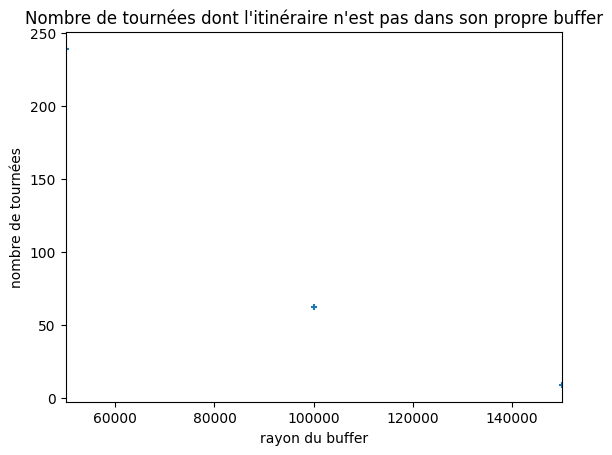

In [22]:
def sample_in_buffer(tournee, dist):
    """
    explication
    Args:
        tournee {geopandas Geodataframe line}: a row of an geodataframe
        dist {int}: buffer size in meters
    """
    geometry_buffer = tournee['cheflieu'].map(wkt.loads)
    tournee_buffer = gpd.GeoDataFrame(tournee, geometry=geometry_buffer, crs = 'EPSG:2154') # we get the center of the cheflieu as a geometry
    tournee_buffer['buffer'] = tournee_buffer.geometry.buffer(dist) # create the buffer based on the cheflieu point
    tournee_buffer = tournee_buffer.drop(columns=['ID_COM']) # drop the column to do the jointure
    tournee_buffer = gpd.GeoDataFrame(tournee_buffer, geometry='buffer') # we set the buffer as the gdf geometry

    geometry_iti = tournee['itineraire'].map(wkt.loads)
    tournee_iti = gpd.GeoDataFrame(tournee, geometry=geometry_iti, crs = 'EPSG:2154') #we set the line as a geometry

    IsIn = tournee_buffer.sjoin(tournee_iti, predicate='contains', how='inner') # we join with lines from the simulations from before the manipulation

    return IsIn.shape[0]

def sample_notIN(gdf, dist):
    nbr_notIn = 0
    n = gdf.shape[0]
    for i in range(n):
        sample = gdf.iloc[[i]]
        if sample_in_buffer(sample, dist) == 0 :
            nbr_notIn += 1
    return nbr_notIn

def graph_notIn(gdf, D):
    nbr = []
    for d in D:
        nbr.append(sample_notIN(gdf, d))
    plt.scatter(D, nbr, s=20, marker='+')
    plt.title("Nombre de tournées dont l'itinéraire n'est pas dans son propre buffer")
    plt.ylabel("nombre de tournées")
    plt.xlabel("rayon du buffer")
    plt.xlim(D[0], D[-1])
    plt.show()


graph_notIn(gdf, D)

# faire un histo plutôt
